## Overall Modeling Process

## 1. Loading Data
- Flattened the nested JSON to extract the data in the right format.

## 2. Data Sanity Checks

### 2.1 Data Shapes and UID Counts
- Checked shapes of each DataFrame.
- Counted unique `UID` values.

### 2.2 Missing Values
- Checked for missing values in all columns.

### 2.3 Duplicate Rows
- Check for duplicate rows

### 2.4 UID Overlap Across Datasets
- Verified overlaps in UID between flag data and the other two datasets.

## 3. EDA for each Dataset

### 3.1 Flags Dataset
1. Target distribution checks
2. Distribution of `name_contract_type` across the target.

### 3.2 Accounts Dataset
1. Check if loan amount and amount overdue is -ve for any instance
2. Checking min/max dates to identify incorrect entries
3. Cases where closed_date<open_date
4. Check for irregularities in payment string column
5. Boxplots to check outliers
6. Plots to see the distribution of loan amount and amount overdue

### 3.3 Enquiry Data
1. Check if enquiry amount is -ve in any case
2. Checking the min and max enquiry dates

### 3.4 Data Cleaning Function

## 4. Feature Engineering
1. Features for both enquiry and accounts data were created separately at uid level and then merged with the flags data. This process was simplified using a function so can be directly used on test data

## 5. Feature Selection (not actively used)
1. Used RFE-based approach where a LGBM model is run and the feature with least importance is removed at each step

## 6. Model Training
1. Training a base lgbm classifiera
2. Training a base catboost classifier

## 7. Hyperparameter tuning
1. Used optuna for hyperparameter tuning

## 8. Predictions on Test Data




# Importing Libraries

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
import optuna
import pickle

# 1. Loading Data

In [2]:
####################### loading flag labels ########################################

df_flag = pd.read_csv('train_flag.csv')

# cunt of unique uid - 261383
# shape - (261383,3)

####################### loading accounts data ########################################

#since we have a JSON with format as list -> list -> dictionary, we flatten it out to convert it to a dataframe

#extracting account data
with open('accounts_data_train.json', 'r') as file:
    nested_data_acc = json.load(file)  
    
flattened_data_acc = [record for sublist in nested_data_acc for record in sublist]

df_acc = pd.DataFrame(flattened_data_acc)
# count of unique uid - 223918
# shape - (1245310,7)

####################### loading enquiry data ########################################

#extracting enquiry data
with open('enquiry_data_train.json', 'r') as file:
    nested_data_enq = json.load(file)  
    
flattened_data_enq = [record for sublist in nested_data_enq for record in sublist]

df_enq = pd.DataFrame(flattened_data_enq)

# count of unique uid - 261383 
# shape - (1909926,7)

In [17]:
pd.DataFrame(df_acc['uid'].unique()).to_excel('test3.xlsx')

In [90]:
df_enq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909926 entries, 0 to 1909925
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   enquiry_type  object
 1   enquiry_amt   int64 
 2   enquiry_date  object
 3   uid           object
dtypes: int64(1), object(3)
memory usage: 58.3+ MB


In [35]:
df_acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245310 entries, 0 to 1245309
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   credit_type          1245310 non-null  object 
 1   loan_amount          1245307 non-null  float64
 2   amount_overdue       1245310 non-null  float64
 3   open_date            1245310 non-null  object 
 4   closed_date          782275 non-null   object 
 5   payment_hist_string  1245310 non-null  object 
 6   uid                  1245310 non-null  object 
dtypes: float64(2), object(5)
memory usage: 66.5+ MB


In [91]:
df_flag.info()
#club  - [('Another type of loan','Unknown type of loan'),('','')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   uid                 261383 non-null  object
 1   NAME_CONTRACT_TYPE  261383 non-null  object
 2   TARGET              261383 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.0+ MB


# 2. Data Sanity 

In [6]:
#2.1 Checking shapes for each of the dataframes and the count of unique UID values

### Insights - 
    # a. Each UID has a single flag but can have multiple past accounts and enquiries
    # b. Unique number of UID in flags and acc is different, indicating not each UID has a past loan, or there's a data pull issue
    # c. Each UID seems to have past enquiry information, which will be verified further
print("flag:", df_flag.shape, ", unique uids:", df_flag['uid'].nunique())
print("accounts:", df_acc.shape, ", unique uids:", df_acc['uid'].nunique())
print("enquiry:", df_enq.shape, ", unique uids:", df_enq['uid'].nunique())

flag: (261383, 3) , unique uids: 261383
accounts: (1245310, 7) , unique uids: 223918
enquiry: (1909926, 4) , unique uids: 261383


In [7]:
#2.2 Check for missing values

## Insights -
    # a. Need to make a decision on how to tackle the large number of nulls in closed_date, most of them indicate that a loan is still open at time of application
print("Missing values in df_flag:")
print(df_flag.isna().sum())

print("\nMissing values in df_acc:")
print(df_acc.isna().sum())

print("\nMissing values in df_enq:")
print(df_enq.isna().sum())

Missing values in df_flag:
uid                   0
NAME_CONTRACT_TYPE    0
TARGET                0
dtype: int64

Missing values in df_acc:
credit_type                 0
loan_amount                 3
amount_overdue              0
open_date                   0
closed_date            463035
payment_hist_string         0
uid                         0
dtype: int64

Missing values in df_enq:
enquiry_type    0
enquiry_amt     0
enquiry_date    0
uid             0
dtype: int64


In [8]:
#2.3 Check for duplicate rows

### Insights - 
    # a. Large number of duplicates in accounts will be removed. Some duplicates present in df_enq too will be removed
print("\nDuplicate rows in df_flag:", df_flag.duplicated().sum())
print("Duplicate rows in df_acc:", df_acc.duplicated().sum())
print("Duplicate rows in df_enq:", df_enq.duplicated().sum())


Duplicate rows in df_flag: 0
Duplicate rows in df_acc: 6411
Duplicate rows in df_enq: 9


In [9]:
#2.4 Checks for UID count overlaps between the flag and the other two datasets (based on findings of 2.1)

### Insights - 
    # a. 37465 UID's don't have any historical loan data, they only have enquiry data
print('Missing UID in flag not in account data', (~df_flag['uid'].isin(df_acc['uid'])).sum())
print('Missing UID in flag not in enquiry data', (~df_flag['uid'].isin(df_enq['uid'])).sum())

Missing UID in flag not in account data 37465
Missing UID in flag not in account data 0


# 3. EDA for each Dataset

3.1 Basic EDA for flags data

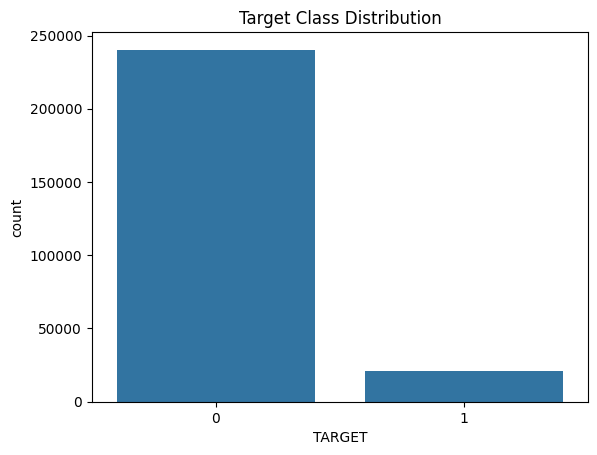

In [11]:
#1. Target distribution

### Insights - 
    # a. We can see that there is a high imbalance in the target, something to be kept in mind while model training and evaluation

sns.countplot(x='TARGET', data=df_flag)
plt.title('Target Class Distribution')
plt.show()

In [12]:
# % data in for each target (this shows there's a very high data imbalance)
(df_flag['TARGET'].value_counts() / df_flag.shape[0]) *100

TARGET
0    91.944006
1     8.055994
Name: count, dtype: float64

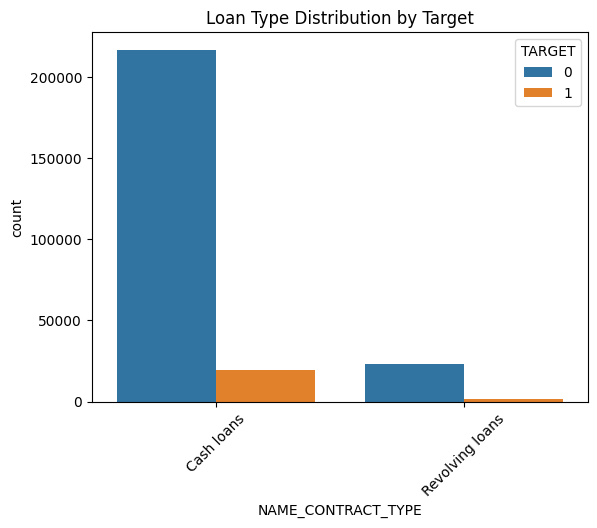

In [13]:
#2. Distribution of name_contract_type across the target

### Insights - 
    # a. large number of defaults from cash loans

sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=df_flag)
plt.title('Loan Type Distribution by Target')
plt.xticks(rotation=45)
plt.show()

B. Basic EDA for accounts data

In [14]:
#1. Check if loan amount and amount overdue is -ve for any instance

### Insights - 
    # a. There are no negatives in both
print("Any negative loan_amount?", (df_acc_dedupe['loan_amount'] < 0).any())
print("Any negative amount_overdue?", (df_acc_dedupe['amount_overdue'] < 0).any())

Any negative loan_amount? False
Any negative amount_overdue? False


In [15]:
#2. Checking min and max dates to see abnormal entries 

### Insights - 
    # a. We see that closed_date has an abnormal value, this we can check for how many cases closed date is less than open_date and take a decision
    # on removing such data points due to incorrectness in recording the data
df_acc_dedupe['open_date'] = pd.to_datetime(df_acc_dedupe['open_date'], errors='coerce')
df_acc_dedupe['closed_date'] = pd.to_datetime(df_acc_dedupe['closed_date'], errors='coerce')

print("open_date min:", df_acc_dedupe['open_date'].min())
print("open_date max:", df_acc_dedupe['open_date'].max())

print("closed_date min:", df_acc_dedupe['closed_date'].min())
print("closed_date max:", df_acc_dedupe['closed_date'].max())

C:\Users\lenvo\AppData\Local\Temp\ipykernel_4776\3930286735.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc_dedupe['open_date'] = pd.to_datetime(df_acc_dedupe['open_date'], errors='coerce')


open_date min: 2013-01-01 00:00:00
open_date max: 2021-01-01 00:00:00
closed_date min: 1905-12-13 00:00:00
closed_date max: 2021-01-01 00:00:00


C:\Users\lenvo\AppData\Local\Temp\ipykernel_4776\3930286735.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc_dedupe['closed_date'] = pd.to_datetime(df_acc_dedupe['closed_date'], errors='coerce')


In [16]:
#3. Checking for how many cases closed date is less than open date

### Insights - 
    # a. there are 13 cases where closed date is less than open date (can remove such cases as they are smaller in number and might indicate data recording issues)
invalid_dates = df_acc_dedupe[
    (df_acc_dedupe['closed_date'].notna()) &
    (df_acc_dedupe['open_date'].notna()) &
    (df_acc_dedupe['closed_date'] < df_acc_dedupe['open_date'])
]

print(f"Number of rows where closed_date < open_date: {len(invalid_dates)}")

Number of rows where closed_date < open_date: 13


In [17]:
#4. Check for any irregularities in the payment string column

### Insights - 
    # a. We see that not all entries are digit strings, can do further analysis on this
all_digit = df_acc_dedupe['payment_hist_string'].apply(lambda x: str(x).isdigit())
print("All payment_hist_string are digit strings?", all_digit.all())

All payment_hist_string are digit strings? False


In [18]:
# further analysis on step - 4. This shows that we have empty strings in this column
non_digit_rows = df_acc_dedupe[~df_acc_dedupe['payment_hist_string'].apply(lambda x: str(x).isdigit())]
non_digit_rows.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
77,Consumer credit,43200.0,0.0,2019-04-12,2019-05-10,,AAC05666087
117,Consumer credit,68292.0,0.0,2015-12-04,2016-01-02,,AAC60259451
223,Consumer credit,465327.0,0.0,2020-12-29,NaT,,AAD97614038
247,Consumer credit,22500.0,0.0,2019-05-23,2019-06-06,,AAE21955361
349,Consumer credit,22500.0,0.0,2020-11-21,2020-12-15,,AAF29916573


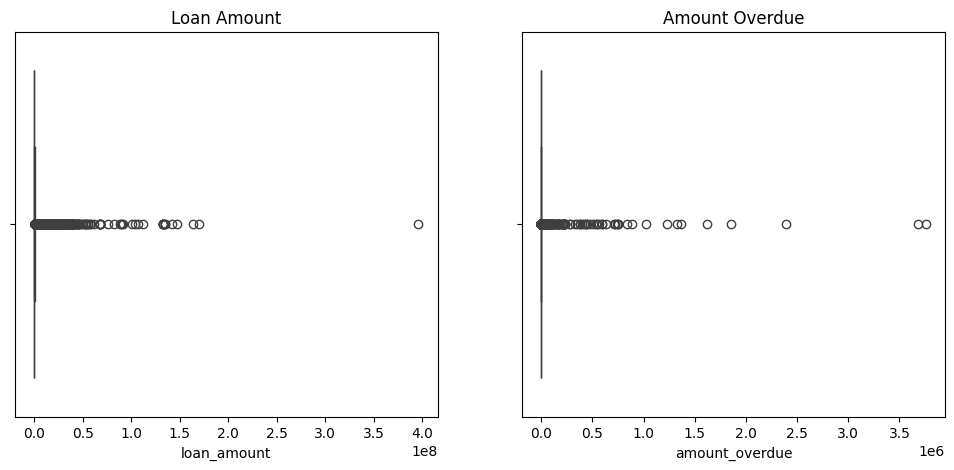

In [19]:
#5. Boxplot to check outliers

### Insights - 
    # a. We do see that there are some outliers based on IQR but we'll not remove them as these can be large loan amounts (tree based models are usually
    # robust to outliers)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df_acc_dedupe['loan_amount'])
plt.title('Loan Amount')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_acc_dedupe['amount_overdue'])
plt.title('Amount Overdue')

plt.show()

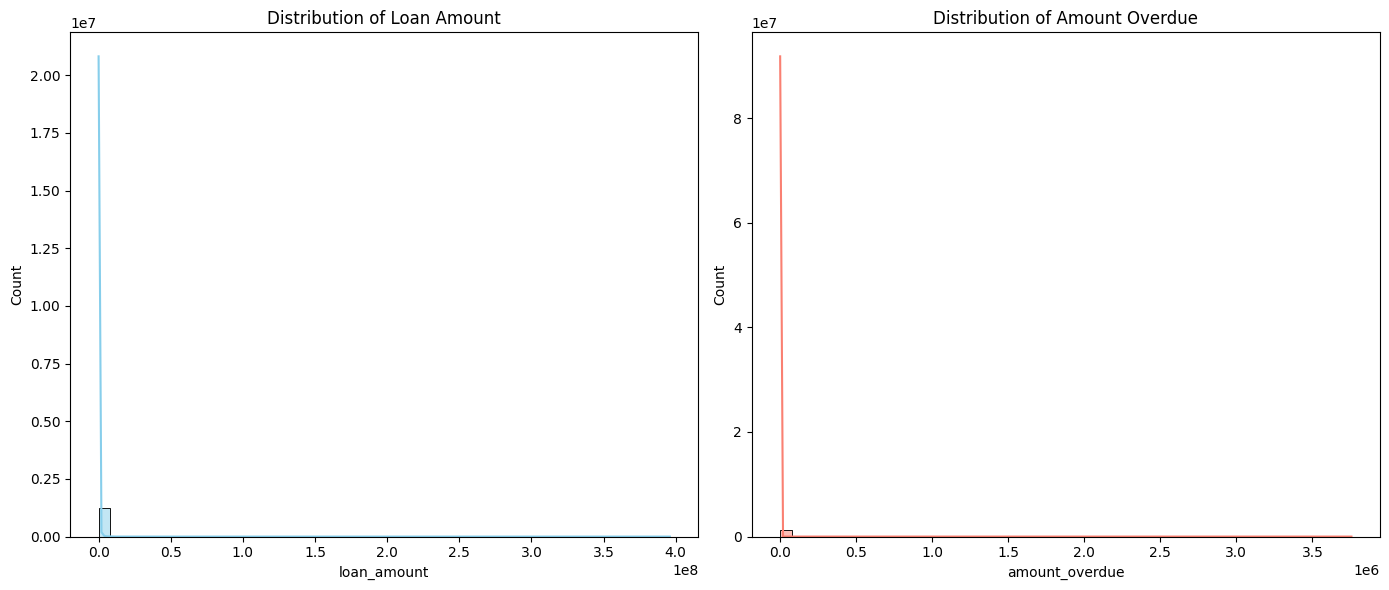

In [20]:
#6. Plots to see the distribution of loan amount and amount overdue (right skewed as expected given the outliers/large values skew the distribution)

plt.figure(figsize=(14, 6))

# Distribution of loan_amount
plt.subplot(1, 2, 1)
sns.histplot(df_acc_dedupe['loan_amount'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of Loan Amount')
plt.xlabel('loan_amount')
plt.ylabel('Count')

# Distribution of amount_overdue
plt.subplot(1, 2, 2)
sns.histplot(df_acc_dedupe['amount_overdue'], kde=True, bins=50, color='salmon')
plt.title('Distribution of Amount Overdue')
plt.xlabel('amount_overdue')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


3.3 Basic EDA for enquiry data

In [21]:
#1. Check if enquiry amount is -ve in any case
print("Any negative enquiry_amt?", (df_enq_dedupe['enquiry_amt'] < 0).any())

Any negative enquiry_amt? False


In [22]:
#2. Checking the min and max enquiry dates for sanity
print("enquiry_date min:", df_enq_dedupe['enquiry_date'].min())
print("enquiry_date max:", df_enq_dedupe['enquiry_date'].max())

enquiry_date min: 2015-08-30
enquiry_date max: 2021-01-01


3.4 Data Cleaning Function

In [3]:
#function to remove any duplicates and cases of dates where close_date<open_date (nased on data sanity checks and basic EDA)
def data_cleaning(df_acc: pd.DataFrame, df_enq: pd.DataFrame):
    
    #1. Remove duplicates
    df_acc_dedupe = df_acc.drop_duplicates()
    df_enq_dedupe = df_enq.drop_duplicates()
    
    #2. Removing cases where closed_date < open_date
    df_acc_dedupe = df_acc_dedupe[~(
        (df_acc_dedupe['closed_date'].notna()) &
        (df_acc_dedupe['closed_date'] < df_acc_dedupe['open_date'])
    )].copy()

    return df_acc_dedupe, df_enq_dedupe

df_acc_dedupe, df_enq_dedupe = data_cleaning(df_acc, df_enq)

# 4. Feature Engineering

A. Feature Engineering for Accounts Data (depreciated, combined into a function)

In [ ]:
# #1. Creating frequency encoding and time based features
# # Frequency encoding of credit_type
# credit_type_freq = df_acc_dedupe['credit_type'].value_counts(normalize=True)
# df_acc_dedupe['credit_type_freq'] = df_acc_dedupe['credit_type'].map(credit_type_freq)

# # Duration calculation (we'll leave the nulls as it is so the model directionally knows these loans are still open)
# df_acc_dedupe['loan_duration_days'] = (
#     df_acc_dedupe['closed_date'] - df_acc_dedupe['open_date']
# ).dt.days


In [ ]:
# #2. Features based on loan amount and # of active loans
# acc_loan_amount_feats = df_acc_dedupe.groupby('uid').agg(
#     acc_total_loans=('loan_amount', 'count'),
#     acc_active_loans=('closed_date', lambda x: x.isna().sum()),
#     acc_closed_loans=('closed_date', lambda x: x.notna().sum()),
#     acc_avg_loan_amount=('loan_amount', 'mean'),
#     acc_max_loan_amount=('loan_amount', 'max'),
#     acc_sum_loan_amount=('loan_amount', 'sum'),
#     acc_loan_amount_std=('loan_amount', 'std')
# ).reset_index()

# credit_type_enc = df_acc_dedupe.groupby('uid')['credit_type_freq'].mean().reset_index().rename(
#     columns={'credit_type_freq': 'acc_credit_type_score'}
# )

In [ ]:
# #sanity check for features created above

# print("Loan Amount Features:")
# print(acc_loan_amount_feats.describe())
# print("Missing values in acc_loan_amount_feats:")
# print(acc_loan_amount_feats.isna().sum())

# # Plot for outlier or skew check
# sns.boxplot(data=acc_loan_amount_feats[['acc_avg_loan_amount', 'acc_max_loan_amount', 'acc_sum_loan_amount']])
# plt.xticks(rotation=45)
# plt.title("Loan Amount Feature Distributions")
# plt.show()


In [ ]:
# #3. Features based on loan amount overdue
# acc_overdue_feats = df_acc_dedupe.groupby('uid').agg(
#     acc_total_overdue=('amount_overdue', 'sum'),
#     acc_avg_overdue=('amount_overdue', 'mean'),
#     acc_max_overdue=('amount_overdue', 'max')
# ).reset_index()

# acc_overdue_feats = acc_overdue_feats.merge(
#     acc_loan_feats[['uid', 'acc_sum_loan_amount']], on='uid', how='left'
# )
# acc_overdue_feats['acc_overdue_amount_ratio'] = (
#     acc_overdue_feats['acc_total_overdue'] / (acc_overdue_feats['acc_sum_loan_amount'] + 1e-6)
# )
# acc_overdue_feats.drop(columns='acc_sum_loan_amount', inplace=True)


In [ ]:
# #sanity checks for the featues created above

# print("Overdue Features:")
# print(acc_overdue_feats.describe())
# print("Missing values in acc_overdue_feats:")
# print(acc_overdue_feats.isna().sum())

# # Check % of users with any overdue
# print("Users with non-zero overdue amount:",
#       (acc_overdue_feats['acc_total_overdue'] > 0).sum(), "/", len(acc_overdue_feats))

# # Check if overdue/loan ratios are bounded between 0 and 1+ (can exceed 1 in rare bad cases)
# print("Overdue ratio > 1:", (acc_overdue_feats['acc_overdue_amount_ratio'] > 1).sum())


In [ ]:
# #4. Features based on loan_duration_days

# acc_tenure_feats = df_acc_dedupe.groupby('uid').agg(
#     acc_avg_loan_duration_days=('loan_duration_days', 'mean'),   # skips NaNs
#     acc_max_loan_duration_days=('loan_duration_days', 'max')     # skips NaNs
# ).reset_index()

# acc_tenure_feats['acc_avg_duration_per_loan'] = acc_tenure_feats['acc_avg_loan_duration_days']

In [ ]:
# #sanity checks for the features created above

# print("Tenure Features:")
# print(acc_tenure_feats.describe())
# print("Missing values in acc_tenure_feats:")
# print(acc_tenure_feats.isna().sum())

# # Check for negative durations (should not happen)
# print("Negative durations?",
#       (acc_tenure_feats[['acc_avg_loan_duration_days', 'acc_max_loan_duration_days']] < 0).any())


In [ ]:
# #5. Features based on payment_hist_string
# def parse_payment_hist(s):
#     if pd.isna(s) or not isinstance(s, str):
#         return []
#     return [int(s[i:i+3]) for i in range(0, len(s), 3)]

# df_acc_dedupe['overdue_list'] = df_acc_dedupe['payment_hist_string'].apply(parse_payment_hist)

In [ ]:
# # creating features to track DPD using the manipulation done above
# def get_ph_features(overdues):
#     if not overdues:
#         return pd.Series({
#             'ph_num_months': 0,
#             'ph_num_on_time': 0,
#             'ph_num_late': 0,
#             'ph_max_overdue': np.nan,
#             'ph_avg_overdue': np.nan,
#             'ph_std_overdue': np.nan,
#             'ph_recent_overdue': np.nan,
#             'ph_num_very_late': 0
#         })
    
#     overdues = np.array(overdues)
#     return pd.Series({
#         'ph_num_months': len(overdues),
#         'ph_num_on_time': np.sum(overdues == 0),
#         'ph_num_late': np.sum(overdues > 0),
#         'ph_max_overdue': np.max(overdues),
#         'ph_avg_overdue': np.mean(overdues),
#         'ph_std_overdue': np.std(overdues),
#         'ph_recent_overdue': overdues[-1],
#         'ph_num_very_late': np.sum(overdues > 30)
#     })

# ph_features = df_acc_dedupe['overdue_list'].apply(get_ph_features)
# df_acc_dedupe = pd.concat([df_acc_dedupe, ph_features], axis=1)


In [ ]:
# # creating features at a UID level
# ph_uid_feats = df_acc_dedupe.groupby('uid').agg(
#     ph_avg_num_months=('ph_num_months', 'mean'),
#     ph_total_num_on_time=('ph_num_on_time', 'sum'),
#     ph_total_num_late=('ph_num_late', 'sum'),
#     ph_max_overdue=('ph_max_overdue', 'max'),
#     ph_avg_overdue=('ph_avg_overdue', 'mean'),
#     ph_std_overdue=('ph_std_overdue', 'mean'),
#     ph_avg_recent_overdue=('ph_recent_overdue', 'mean'),
#     ph_total_very_late=('ph_num_very_late', 'sum')
# ).reset_index()

In [ ]:
# #merging all features with features with df_flag

# # Start with base set (e.g., df_flag with uid)
# df_features = df_flag.copy()

# # Merge all feature sets
# df_features = df_features.merge(acc_loan_feats, on='uid', how='left')
# df_features = df_features.merge(credit_type_enc, on='uid', how='left')
# df_features = df_features.merge(acc_overdue_feats, on='uid', how='left')
# df_features = df_features.merge(acc_tenure_feats, on='uid', how='left')
# df_features = df_features.merge(ph_uid_feats, on='uid', how='left')

# # Sanity checks
# print("Final shape:", df_features.shape)
# print("Missing values:\n", df_features.isna().sum())


In [ ]:
# print(df_features.shape)
# print(df_features[['ph_avg_overdue', 'ph_max_overdue', 'ph_total_num_late']].describe())
# print("Nulls in new repayment features:\n", df_features.filter(like='ph_').isna().sum())

B. Feature Engineering for Enquiry data (depreciated, combined into a function)


In [ ]:
# # 1. Grouping by uid to create features
# enq_features = df_enq_dedupe.groupby('uid').agg(
#     enq_total_enquiries=('enquiry_amt', 'count'),
#     enq_avg_enquiry_amt=('enquiry_amt', 'mean'),
#     enq_max_enquiry_amt=('enquiry_amt', 'max'),
#     enq_total_enquiry_amt=('enquiry_amt', 'sum'),
#     enq_types_count=('enquiry_type', pd.Series.nunique)
# ).reset_index()

In [ ]:
# #checks on the features created above

# print("Enquiry Features Summary:")
# print(enq_features.describe())

# print("\nMissing values in enquiry features:")
# print(enq_features.isna().sum())

# # Plot to see distribution
# enq_features[['enq_total_enquiries', 'enq_avg_enquiry_amt', 'enq_total_enquiry_amt']].hist(figsize=(10, 5))
# plt.suptitle("Distribution of Enquiry Features")
# plt.show()


In [ ]:
# # Merge on uid
# df_features_2 = df_features.merge(enq_features, on='uid', how='left')
# df_features_2.shape

In [101]:
# function that combines the entire feature engineering process 
def feat_eng(df_flag: pd.DataFrame, df_acc_dedupe: pd.DataFrame, df_enq_dedupe: pd.DataFrame):
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd

    #################################### --- Feature Engineering on Account Data --- #############################################################
    
    ########### 1. Features by mapping credit type based smaller coherent categories 
    def map_credit_type(ct):
        if ct in ['Cash loan (non-earmarked)', 'Consumer credit', 'Microloan', 'Mobile operator loan']:
            return 'retail_personal'
        elif ct in ['Car loan', 'Mortgage', 'Real estate loan']:
            return 'retail_secured_asset'
        elif ct in ['Credit card', 'Loan for purchase of shares (margin lending)']:
            return 'retail_revolving'
        elif ct in ['Loan for working capital replenishment', 'Loan for business development', 'Loan for the purchase of equipment']:
            return 'business_purposeed'
        elif ct in ['Interbank credit']:
            return 'institutional'
        else:
            return 'ambiguous_other'

    df_acc_dedupe['credit_type_group'] = df_acc_dedupe['credit_type'].apply(map_credit_type)

    # one hot encode and group by uid to roll up at uid level 
    credit_type_ohe = pd.get_dummies(df_acc_dedupe['credit_type_group'], prefix='acc_type')
    df_acc_ohe = pd.concat([df_acc_dedupe[['uid']], credit_type_ohe], axis=1)
    acc_group_feats = df_acc_ohe.groupby('uid').sum().reset_index()

    ########### 2. Features from open date and closed date
    df_acc_dedupe['open_date'] = pd.to_datetime(df_acc_dedupe['open_date'], errors='coerce') #coerce takes care of nulls while conversion to datetime
    df_acc_dedupe['closed_date'] = pd.to_datetime(df_acc_dedupe['closed_date'], errors='coerce')

    df_acc_dedupe['loan_duration_days'] = (
        df_acc_dedupe['closed_date'] - df_acc_dedupe['open_date']
    ).dt.days

    # group by at uid level to create features using tenure
    acc_tenure_feats = df_acc_dedupe.groupby('uid').agg(
        acc_avg_loan_duration_days=('loan_duration_days', 'mean'),
        acc_max_loan_duration_days=('loan_duration_days', 'max')
    ).reset_index()
    acc_tenure_feats['acc_avg_duration_per_loan'] = acc_tenure_feats['acc_avg_loan_duration_days']

    ########### 3. Features from loan amount and closed date
    acc_loan_feats = df_acc_dedupe.groupby('uid').agg(
        acc_total_loans=('loan_amount', 'count'),
        acc_active_loans=('closed_date', lambda x: x.isna().sum()),
        acc_closed_loans=('closed_date', lambda x: x.notna().sum()),
        acc_avg_loan_amount=('loan_amount', 'mean'),
        acc_max_loan_amount=('loan_amount', 'max'),
        acc_sum_loan_amount=('loan_amount', 'sum'),
        acc_loan_amount_std=('loan_amount', 'std')
    ).reset_index()

    ########### 4. Features from amount_overdue
    acc_overdue_feats = df_acc_dedupe.groupby('uid').agg(
        acc_total_overdue=('amount_overdue', 'sum'),
        acc_avg_overdue=('amount_overdue', 'mean'),
        acc_max_overdue=('amount_overdue', 'max')
    ).reset_index()

    # manipulation for overdue/loan_amount ratio
    acc_overdue_feats = acc_overdue_feats.merge(
        acc_loan_feats[['uid', 'acc_sum_loan_amount']], on='uid', how='left'
    )
    acc_overdue_feats['acc_overdue_amount_ratio'] = (
        acc_overdue_feats['acc_total_overdue'] / (acc_overdue_feats['acc_sum_loan_amount'] + 1e-6)
    )
    acc_overdue_feats.drop(columns='acc_sum_loan_amount', inplace=True)

    
    ########### 5. Features from payment_hist_string
    #creating a list of integers from the string where each value is each months overdue
    def parse_payment_hist(s):
        if pd.isna(s) or not isinstance(s, str):
            return []
        return [int(s[i:i+3]) for i in range(0, len(s), 3)]

    df_acc_dedupe['overdue_list'] = df_acc_dedupe['payment_hist_string'].apply(parse_payment_hist)

    # function to create features from overdue_list
    def get_ph_features(overdues):
        if not overdues:
            return pd.Series({
                'ph_num_months': 0,
                'ph_num_on_time': 0,
                'ph_num_late': 0,
                'ph_max_overdue': np.nan,
                'ph_avg_overdue': np.nan,
                'ph_std_overdue': np.nan,
                'ph_recent_overdue': np.nan,
                'ph_num_very_late': 0
            })
        overdues = np.array(overdues)
        return pd.Series({
            'ph_num_months': len(overdues), #duration of payments
            'ph_num_on_time': np.sum(overdues == 0),
            'ph_num_late': np.sum(overdues > 0),
            'ph_max_overdue': np.max(overdues),
            'ph_avg_overdue': np.mean(overdues),
            'ph_std_overdue': np.std(overdues),
            'ph_recent_overdue': overdues[-1],
            'ph_num_very_late': np.sum(overdues > 30)
        })

    ph_features = df_acc_dedupe['overdue_list'].apply(get_ph_features)
    df_acc_dedupe = pd.concat([df_acc_dedupe, ph_features], axis=1)

    ph_uid_feats = df_acc_dedupe.groupby('uid').agg(
        ph_avg_num_months=('ph_num_months', 'mean'),
        ph_total_num_on_time=('ph_num_on_time', 'sum'),
        ph_total_num_late=('ph_num_late', 'sum'),
        ph_max_overdue=('ph_max_overdue', 'max'),
        ph_avg_overdue=('ph_avg_overdue', 'mean'),
        ph_std_overdue=('ph_std_overdue', 'mean'),
        ph_avg_recent_overdue=('ph_recent_overdue', 'mean'),
        ph_total_very_late=('ph_num_very_late', 'sum')
    ).reset_index()


    #################################### --- Feature Engineering on Enquiry Data --- #############################################################
    
    #1. Creating features for enquiry type category columns
    def group_loan_type(loan_type):
        if loan_type in [
            'Cash loans', 'Cash loan (non-earmarked)', 'Consumer credit',
            'Microloan', 'Mobile operator loan'
        ]:
            return 'Retail - Personal'
        elif loan_type in ['Car loan', 'Mortgage', 'Real estate loan']:
            return 'Retail - Secured Asset'
        elif loan_type in ['Revolving loans', 'Credit card', 'Loan for purchase of shares (margin lending)']:
            return 'Retail - Revolving'
        elif loan_type in [
            'Loan for working capital replenishment',
            'Loan for business development',
            'Loan for the purchase of equipment'
        ]:
            return 'Business - Purposeed'
        else:
            return 'Ambiguous / Other'

    df_enq_dedupe['loan_type_group'] = df_enq_dedupe['enquiry_type'].apply(group_loan_type)

    enq_group_ohe = pd.get_dummies(df_enq_dedupe['loan_type_group'], prefix='enq_type')
    df_enq_ohe = pd.concat([df_enq_dedupe[['uid']], enq_group_ohe], axis=1)
    enq_group_feats = df_enq_ohe.groupby('uid').sum().reset_index()

    #2. Creating features from enquiry amount
    enq_features = df_enq_dedupe.groupby('uid').agg(
    enq_total_enquiries=('enquiry_amt', 'count'),
    enq_avg_enquiry_amt=('enquiry_amt', 'mean'),
    enq_max_enquiry_amt=('enquiry_amt', 'max'),
    enq_total_enquiry_amt=('enquiry_amt', 'sum'),
    enq_types_count=('enquiry_type', pd.Series.nunique)
    ).reset_index()

    # enq_features[['enq_total_enquiries', 'enq_avg_enquiry_amt', 'enq_total_enquiry_amt']].hist(figsize=(10, 5))
    # plt.suptitle("Distribution of Enquiry Features")
    # plt.show()

    #################################### --- Merge all Feature DataFrames --- #############################################################

    #frequency encoding contract type features
    contract_type_freq = df_flag['NAME_CONTRACT_TYPE'].value_counts(normalize=True).to_dict()
    df_flag['NAME_CONTRACT_TYPE_FE'] = df_flag['NAME_CONTRACT_TYPE'].map(contract_type_freq)
    
    df_features = df_flag.copy()
    df_features = df_features.merge(acc_loan_feats, on='uid', how='left')
    df_features = df_features.merge(acc_overdue_feats, on='uid', how='left')
    df_features = df_features.merge(acc_tenure_feats, on='uid', how='left')
    df_features = df_features.merge(ph_uid_feats, on='uid', how='left')
    df_features = df_features.merge(enq_features, on='uid', how='left')
    df_features = df_features.merge(enq_group_feats, on='uid', how='left')
    df_features = df_features.merge(acc_group_feats, on='uid', how='left')

    print("Features Summary:")
    print(df_features.describe())

    print("\nMissing values in features:")
    print(df_features.isna().sum())
    
    return df_features

df_features = feat_eng(df_flag, df_acc_dedupe, df_enq_dedupe)

C:\Users\lenvo\AppData\Local\Temp\ipykernel_42484\2402737514.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enq_dedupe['loan_type_group'] = df_enq_dedupe['enquiry_type'].apply(group_loan_type)


Features Summary:
              TARGET  NAME_CONTRACT_TYPE_FE  acc_total_loans  \
count  261383.000000          261383.000000    223918.000000   
mean        0.080560               0.827879         5.532758   
std         0.272159               0.237561         4.357408   
min         0.000000               0.095106         0.000000   
25%         0.000000               0.904894         2.000000   
50%         0.000000               0.904894         4.000000   
75%         0.000000               0.904894         8.000000   
max         1.000000               0.904894       116.000000   

       acc_active_loans  acc_closed_loans  acc_avg_loan_amount  \
count     223918.000000     223918.000000         2.239170e+05   
mean           2.050286          3.482480         3.788428e+05   
std            1.771395          3.381882         9.153089e+05   
min            0.000000          0.000000         0.000000e+00   
25%            1.000000          1.000000         1.035000e+05   
50%      

# 5. Feature Selection

In [102]:
#splitting the df_features into train and validation sets
X = df_features.drop(columns=['TARGET','uid','NAME_CONTRACT_TYPE'])
y = df_features['TARGET']
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Features: 39 | AUC: 0.63044
#Features: 38 | AUC: 0.63044
#Features: 37 | AUC: 0.63044
#Features: 36 | AUC: 0.63029
#Features: 35 | AUC: 0.63027
#Features: 34 | AUC: 0.63041
#Features: 33 | AUC: 0.63006
#Features: 32 | AUC: 0.63025
#Features: 31 | AUC: 0.63073
#Features: 30 | AUC: 0.62980
#Features: 29 | AUC: 0.63005
#Features: 28 | AUC: 0.62967
#Features: 27 | AUC: 0.62999
#Features: 26 | AUC: 0.62925
#Features: 25 | AUC: 0.62924
#Features: 24 | AUC: 0.62905
#Features: 23 | AUC: 0.62880
#Features: 22 | AUC: 0.62861
#Features: 21 | AUC: 0.62851
#Features: 20 | AUC: 0.62885
#Features: 19 | AUC: 0.62811
#Features: 18 | AUC: 0.62822
#Features: 17 | AUC: 0.62817
#Features: 16 | AUC: 0.62792
#Features: 15 | AUC: 0.62878
#Features: 14 | AUC: 0.62774
#Features: 13 | AUC: 0.62662
#Features: 12 | AUC: 0.62634
#Features: 11 | AUC: 0.62631
#Features: 10 | AUC: 0.60351
#Features: 9 | AUC: 0.60313
#Features: 8 | AUC: 0.60388
#Features: 7 | AUC: 0.60413
#Features: 6 | AUC: 0.60037
#Features: 5 | AUC

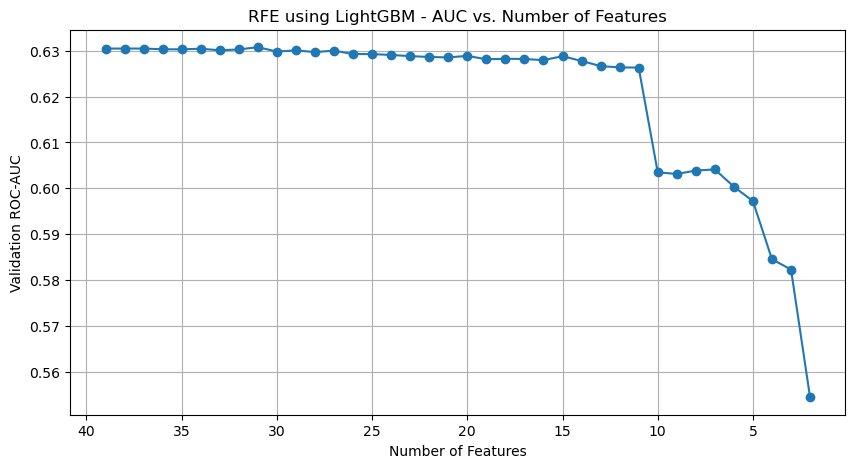

In [103]:
# custom rfe function to find out least important features by checking feature importance in an iterative fashion
def lgbm_rfe_auc(X_train, y_train, X_valid, y_valid, step=1, random_state=2025):
    auc_scores = []
    features_list = []

    # Start with all features
    current_features = list(X_train.columns)

    while len(current_features) > step:
        # Train LightGBM
        model = LGBMClassifier(
            objective='binary',
            boosting_type='gbdt',
            n_estimators=1000,
            learning_rate=0.01,
            random_state=random_state,
            verbose=-1
        )
        model.fit(
            X_train[current_features], y_train,
            eval_set=[(X_valid[current_features], y_valid)],
            eval_metric='auc'
        )

        # Evaluate
        preds = model.predict_proba(X_valid[current_features])[:, 1]
        auc = roc_auc_score(y_valid, preds)
        auc_scores.append(auc)
        features_list.append(len(current_features))

        print(f"#Features: {len(current_features)} | AUC: {auc:.5f}")

        # Get feature importances
        importances = pd.Series(model.feature_importances_, index=current_features)
        least_important = importances.nsmallest(step).index.tolist()

        # Drop least important features
        current_features = [f for f in current_features if f not in least_important]

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(features_list, auc_scores, marker='o')
    plt.xlabel("Number of Features")
    plt.ylabel("Validation ROC-AUC")
    plt.title("RFE using LightGBM - AUC vs. Number of Features")
    plt.gca().invert_xaxis()
    plt.grid(True)
    plt.show()

lgbm_rfe_auc(X_train, y_train, X_valid, y_valid, step=1, random_state=2025)

# 6. Model Training

In [127]:
#1. Training a base lgbm classifier

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Base model with key params
lgb_clf = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    scale_pos_weight=scale_pos_weight,
    n_estimators=1000,
    learning_rate=0.01,
    random_state=2025,
    verbose = -1
)

lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc'
)

# Predict
y_pred_train_lgb = lgb_clf.predict_proba(X_train)[:, 1]
y_pred_valid_lgb = lgb_clf.predict_proba(X_valid)[:, 1]
print("LGBMClassifier ROC-AUC (Train Set):", roc_auc_score(y_train, y_pred_train_lgb))
print("LGBMClassifier ROC-AUC (Validation Set):", roc_auc_score(y_valid, y_pred_valid_lgb))

LGBMClassifier ROC-AUC (Train Set): 0.7062597247850103
LGBMClassifier ROC-AUC (Validation Set): 0.6282770742591796


In [120]:
#2. Training a base catboost classifier
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=0,
    random_state=2025,
    scale_pos_weight=scale_pos_weight
)

model_cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=30)
y_pred_train_cat = model_cat.predict_proba(X_train)[:, 1]
y_pred_valid_cat = model_cat.predict_proba(X_valid)[:, 1]
print("CatboostClassifier ROC-AUC (Train Set):", roc_auc_score(y_train, y_pred_train_cat))
print("CatboostClassifier ROC-AUC (Validation Set):", roc_auc_score(y_valid, y_pred_valid_cat))


CatboostClassifier ROC-AUC (Train Set): 0.6581113835333621
CatboostClassifier ROC-AUC (Validation Set): 0.6304331153822048


In [68]:
(y_pred_train_lgb>0.2).sum()

3269

# 7. Hyperparameter Tuning

In [141]:
best_model = None  # Global variable to hold the best model
best_score = -1

def objective_cat(trial):
    global best_model, best_score

    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 1),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 10),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 1.0),
        'iterations': trial.suggest_int("iterations", 500, 1000),
        'random_state': 2025,
        'verbose': 0,
        'class_weights': [1.0, scale_pos_weight]
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=50,
        use_best_model=True
    )

    preds = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, preds)

    # Saving the best model
    if auc > best_score:
        best_score = auc
        best_model = model

    return auc


study_cat = optuna.create_study(direction="maximize", study_name="catboost_hyperparam_tuning")
study_cat.optimize(objective_cat, n_trials=200)

print("Best CatBoost ROC-AUC:", study_cat.best_value)
print("Best CatBoost Params:", study_cat.best_params)

[I 2025-05-26 21:51:33,456] A new study created in memory with name: catboost_hyperparam_tuning
[I 2025-05-26 21:51:38,163] Trial 0 finished with value: 0.6158235950067983 and parameters: {'learning_rate': 0.8391716315879564, 'depth': 10, 'l2_leaf_reg': 9.316131195239217, 'bagging_temperature': 0.042650778625643815, 'iterations': 566}. Best is trial 0 with value: 0.6158235950067983.
[I 2025-05-26 21:51:41,904] Trial 1 finished with value: 0.6211738904324373 and parameters: {'learning_rate': 0.292236335372889, 'depth': 9, 'l2_leaf_reg': 0.10930791014928935, 'bagging_temperature': 0.8847381084197665, 'iterations': 551}. Best is trial 1 with value: 0.6211738904324373.
[I 2025-05-26 21:51:46,052] Trial 2 finished with value: 0.6310907937547243 and parameters: {'learning_rate': 0.3541040331616676, 'depth': 4, 'l2_leaf_reg': 3.060076077832819, 'bagging_temperature': 0.08800403349250663, 'iterations': 739}. Best is trial 2 with value: 0.6310907937547243.
[I 2025-05-26 21:51:50,116] Trial 3 fi

Best CatBoost ROC-AUC: 0.6329322541673014
Best CatBoost Params: {'learning_rate': 0.08176882186572666, 'depth': 4, 'l2_leaf_reg': 8.716449476528693, 'bagging_temperature': 0.9581287065166211, 'iterations': 656}


In [142]:
#saving the best model in a pickle file
with open("best_catboost_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# 8. Predictions on Test Data

In [110]:
####################### loading flag labels ########################################

df_flag_test = pd.read_csv('C:/Users/lenvo/senior_ds_test/m_creditech_assgn/senior_ds_test/data/test/test_flag.csv')

# count of unique uid - 46127
# shape - (46127,2)

####################### loading accounts data ########################################

#since we have a json format with list -> list -> dictionary, we flatten it out to convert it to a dataframe

#extracting account data
with open('C:/Users/lenvo/senior_ds_test/m_creditech_assgn/senior_ds_test/data/test/accounts_data_test.json', 'r') as file:
    nested_data_acc_test = json.load(file)  
    
flattened_data_acc_test = [record for sublist in nested_data_acc_test for record in sublist]

df_acc_test = pd.DataFrame(flattened_data_acc_test)
# count of unique uid - 
# shape - 

####################### loading enquiry data ########################################

#extracting enquiry data
with open('C:/Users/lenvo/senior_ds_test/m_creditech_assgn/senior_ds_test/data/test/enquiry_data_test.json', 'r') as file:
    nested_data_enq_test = json.load(file)  
    
flattened_data_enq_test = [record for sublist in nested_data_enq_test for record in sublist]

df_enq_test = pd.DataFrame(flattened_data_enq_test)

# count of unique uid - 46127
# shape - (337662,4)

In [111]:
# 1. Clearing the data using the function used for training data
df_acc_dedupe_test, df_enq_dedupe_test = data_cleaning(df_acc_test, df_enq_test)
#2. Feature Engineering for test set 
df_features_test = feat_eng(df_flag_test, df_acc_dedupe_test, df_enq_dedupe_test)

Features Summary:
       NAME_CONTRACT_TYPE_FE  acc_total_loans  acc_active_loans  \
count           46127.000000     39572.000000      39572.000000   
mean                0.826719         5.531891          2.045183   
std                 0.237940         4.317106          1.771179   
min                 0.095822         1.000000          0.000000   
25%                 0.904178         2.000000          1.000000   
50%                 0.904178         4.000000          2.000000   
75%                 0.904178         8.000000          3.000000   
max                 0.904178        49.000000         17.000000   

       acc_closed_loans  acc_avg_loan_amount  acc_max_loan_amount  \
count      39572.000000         3.957200e+04         3.957200e+04   
mean           3.486708         3.709701e+05         9.667998e+05   
std            3.345631         6.940939e+05         1.722368e+06   
min            0.000000         0.000000e+00         0.000000e+00   
25%            1.000000         1

In [143]:
# Loading the best model and scoring on test data
X_test = df_features_test.drop(columns=['uid','NAME_CONTRACT_TYPE'])
X_test['acc_type_institutional'] = np.nan

with open("best_catboost_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

y_pred = loaded_model.predict_proba(X_test)[:, 1]

In [144]:
#saving the test data as a csv
final_submission_aditya_mahala_df = df_flag_test.copy()
final_submission_aditya_mahala_df['pred'] = y_pred
final_submission_aditya_mahala_df.drop(columns=['NAME_CONTRACT_TYPE']).to_csv('C:/Users/lenvo/senior_ds_test/m_creditech_assgn/senior_ds_test/data/test/final_submission_aditya_mahala.csv')